Imports

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, time
from datetime import date
import holidays

!pip install umap-learn
import umap 

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Read the data

In [ ]:
data=pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

data.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


# Exploratory data analysis

Manual dimension reduction. Some attributes are clearly not very useful, some are duplicates.



In [ ]:
data["StandardHours"].unique()
data["Over18"].unique()
data = data.drop(columns = ["EmployeeNumber", "StandardHours", "Over18"])

Check the ratio on the Attrition column.

In [ ]:
data["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [ ]:
def print_stats(col):
  print("Attrition = YES, " + col + " median:", data[data["Attrition"] == "Yes"][col].median())
  print("Attrition = NO, " + col + " median:", data[data["Attrition"] == "No"][col].median())
  print("Attrition = YES, " + col + " mean:", data[data["Attrition"] == "Yes"][col].mean())
  print("Attrition = NO, " + col + " mean:", data[data["Attrition"] == "No"][col].mean())

###Exploratory analysis for `Age`

Observation: Employees tend to leave the company when they are younger. The biggest attrition rate is for mid-age employees (roughly 28-38).

Attrition = YES, Age median: 32.0
Attrition = NO, Age median: 36.0
Attrition = YES, Age mean: 33.607594936708864
Attrition = NO, Age mean: 37.561232765612324


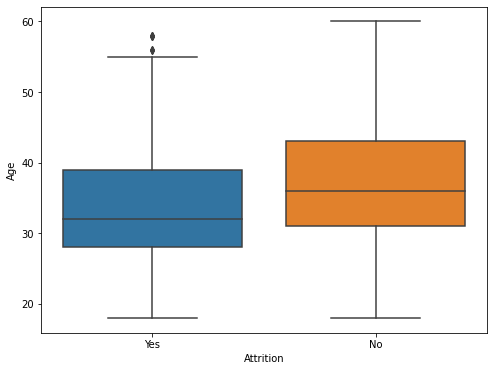

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x = "Attrition", y = "Age", data = data)
print_stats("Age")

From the boxplot as well as from the median and mean, we can see that attrition is higher younger employees.

###Exploratory analysis for `DistanceFromHome`
Observation: Employees tend to leave the company when the workplace is more far from their home.

Attrition = YES, DistanceFromHome median: 9.0
Attrition = NO, DistanceFromHome median: 7.0
Attrition = YES, DistanceFromHome mean: 10.632911392405063
Attrition = NO, DistanceFromHome mean: 8.915652879156529


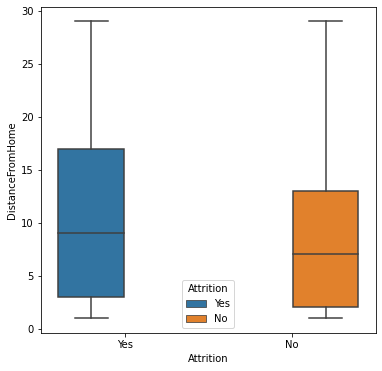

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(x="Attrition",y="DistanceFromHome", data=data, hue="Attrition")
print_stats("DistanceFromHome")

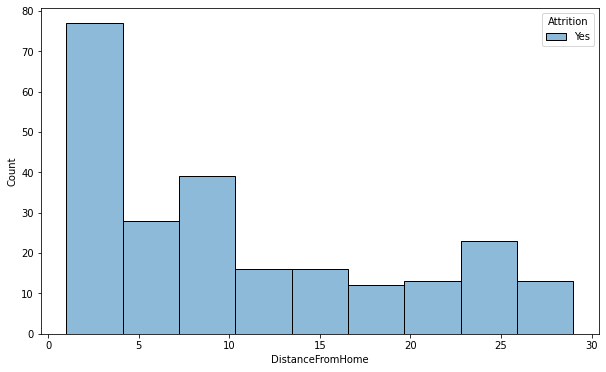

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x="DistanceFromHome", data=data[data["Attrition"] == "Yes"],hue="Attrition")

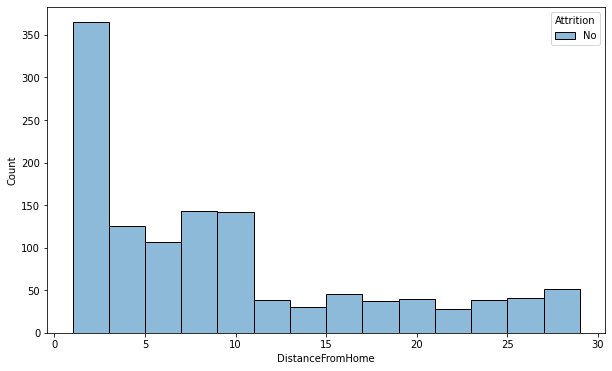

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x="DistanceFromHome", data=data[data["Attrition"] == "No"],hue="Attrition")

From the histplot, we can see, that most employees live up to 10 units from the office. Also employees living close to the office are responsible for **most** attritinons (no conclusions about the rate).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


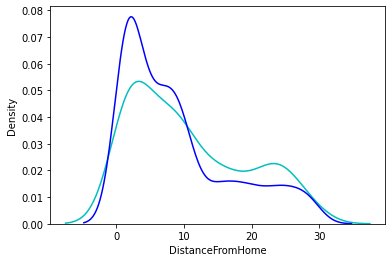

In [ ]:
sns.distplot(data.DistanceFromHome[data.Attrition=='Yes'],label='Attrition',norm_hist=True,color='c',hist=False)
sns.distplot(data.DistanceFromHome[data.Attrition=='No'],label='No Attrition',norm_hist=True,color='b',hist=False)

From the distribution plot, we can see that as distance from home increase, the attrition begins to surpass the non-attrition. The distance, where attrition surpasses non-attrition is roughly 11. This means, that starting from 11 units, the attrittion rate is higher.

###Exploratory analysis for `NumCompaniesWorked`
Observation: Most employees who left has worked in one company

In [ ]:
print_stats("NumCompaniesWorked")

Attrition = YES, NumCompaniesWorked median: 1.0
Attrition = NO, NumCompaniesWorked median: 2.0
Attrition = YES, NumCompaniesWorked mean: 2.940928270042194
Attrition = NO, NumCompaniesWorked mean: 2.6455798864557987


Median and mean does not tell much this time.

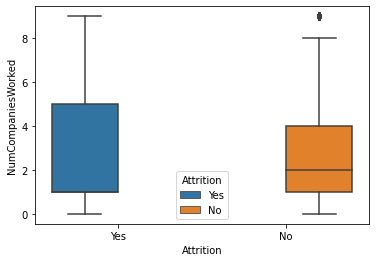

In [ ]:
sns.boxplot(x="Attrition",y="NumCompaniesWorked", data=data, hue="Attrition")

From the boxplot, we can see that the `NumCompaniesWorked` variance of employees who left is higher, than of those who stayed. This is also strengthened by the fact, that there are many more employees that stayed in the dataset.

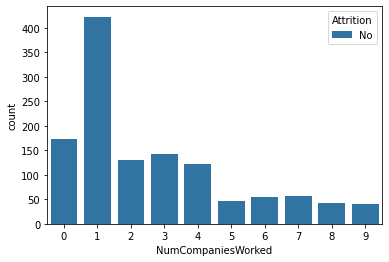

In [ ]:
sns.countplot(x="NumCompaniesWorked", data=data[data["Attrition"] == "No"],hue="Attrition")

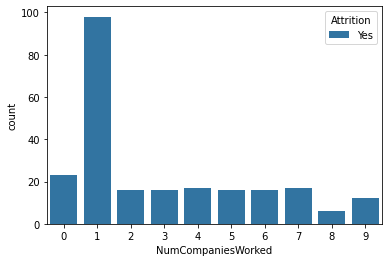

In [ ]:
sns.countplot(x="NumCompaniesWorked", data=data[data["Attrition"] == "Yes"],hue="Attrition")

###Exploratory analysis for `BusinessTravel`
Observation: Most employees who left has traveled rarley. Employees that travel frequently have the biggest attrition rate.

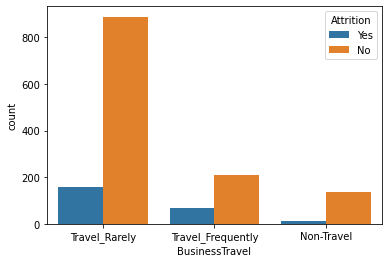

In [ ]:
sns.countplot(x='BusinessTravel',hue='Attrition',data=data)

From the plot above, we can see that mostly `Travel_Rarely` samples are present in the dataset. This indicates, that data are not balanced. So let's see some percentage.

In [ ]:
print('Attriton in Travel_Rarely: ' + 
      str(100*len(data[(data.BusinessTravel=='Travel_Rarely') & (data.Attrition=='Yes')])
      /len(data[data.BusinessTravel=='Travel_Rarely'])) + " %")

print('Attriton in Travel_Frequently: ' +
      str(100*len(data[(data.BusinessTravel=='Travel_Frequently') & (data.Attrition=='Yes')])
      /len(data[data.BusinessTravel=='Travel_Frequently'])) + " %")

print('Attriton in Non_Travel: ' +
      str(100*len(data[(data.BusinessTravel=='Non-Travel') & (data.Attrition=='Yes')])
      /len(data[data.BusinessTravel=='Non-Travel'])) + " %")

Attriton in Travel_Rarely: 14.956855225311601 %
Attriton in Travel_Frequently: 24.90974729241877 %
Attriton in Non_Travel: 8.0 %


Above calculations shows that employees who travel frequently are more likely to leave the company.



###Exploratory analysis for `Overtime`
Observation: The number of people who do not work overtime is higher. Interesting thing in the Attrition is, that the number of people who left the organization and worked overtime is the same as the number of people who left the organization and did not work overtime. We can see this in the middle graph.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Non-Attriton')

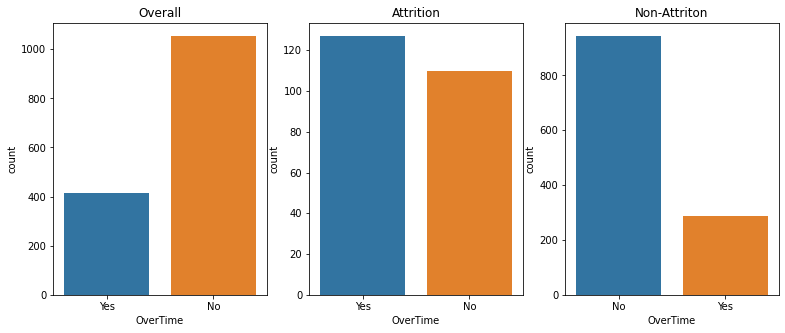

In [ ]:
plt.figure(figsize=(13,5))
plt.subplot(131)
sns.countplot(data.OverTime)
plt.title('Overall')
plt.subplot(132)
sns.countplot(data.OverTime[data.Attrition=='Yes'])
plt.title('Attrition')
plt.subplot(133)
sns.countplot(data.OverTime[data.Attrition=='No'])
plt.title('Non-Attriton')

### Other interesting things

I noticed, that the `JobSatisfaction` is simillar for all job roles, but `Human Resources`. This is clearly visible from the boxplot below

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


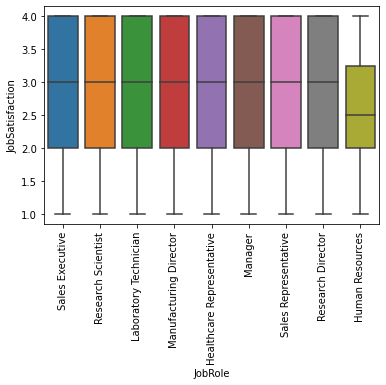

In [ ]:
sns.boxplot(data['JobRole'], data['JobSatisfaction'])
plt.xticks( rotation=90)
plt.show()

### Correlation matrix


In the matrix below, we can observe the correlation of variables. We can see that `Age` correlates with many other variables, mostly with the ones that depends on time (`YearsAt..`). There are also many expected correlations. To give a few examples:


*   `PerformanceRating` & `PercentSalaryHike` - employees with good performance are getting pay rise.
*   `MonthlyIncome` & `JobLevel` - the higher the job level, the more money you get.
*    `YearsAtCompany` & `YearsAtCurrentRole` & `YearsSinceLastPromotion` & `YearsWithCurrentManager` - the more years the employee works in the company, the more years he spends in the current role (I think people tend to stay at one role in the company. When you want to change your role, you usually try your luck in another company.), the more years passed since the last promotion (as the role did not change) and the more years the employee is with current manager. All those variables also correlates with `Age`, as stated above.



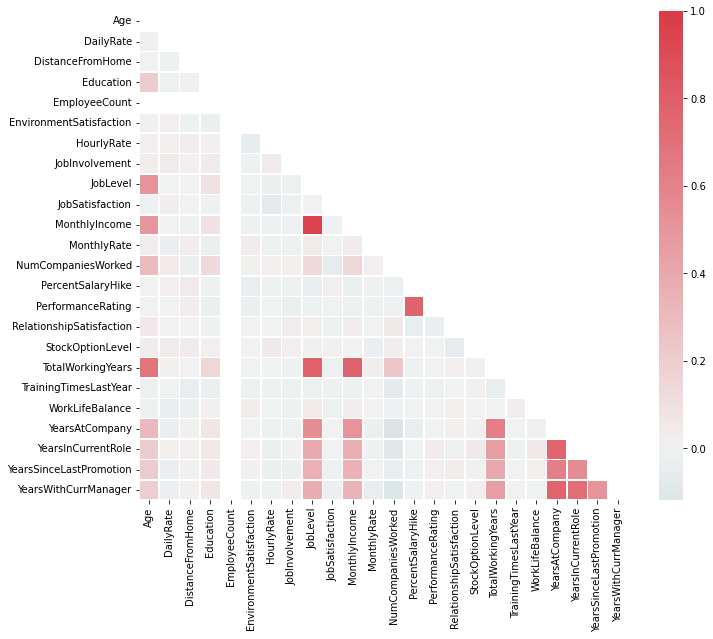

In [ ]:
numeric_hr = data.select_dtypes(include=[np.number])

# Complete the correlation matrix
corr = numeric_hr._get_numeric_data().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                      vmax = 1, square=True, linewidths=.5, ax=ax)
plt.show()

## Clustering & Dimension reduction

At first, we have to get rid of the categorical variables with strings as values, and transform the data, so that they have similar scale.

In [ ]:
dummies = pd.get_dummies(data)

X = dummies.values

scaled_data = StandardScaler().fit_transform(X)

For dimensionality reduction, I decided to use UMAP (Uniform Manifold Approximation and projection). It is a dimesion reduction technique, that is mainly used for visualisation. Compared to other methods, it is pretty fast. 

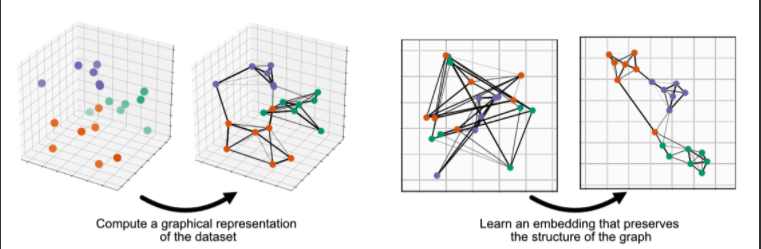

From the original space it finds the relationships. Then it creates a new space where the topology of the original points is respected (original image from UMAP documentation).

**Parameters**

`n_neighbors`: This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP. Increasing the parameter leads to better retaining global structure.

`min_dist`: controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation.

In [ ]:
# Crete the UMAP object
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2)

# Use UMAP on the data
embedding = reducer.fit_transform(scaled_data)
print(embedding.shape)

(1470, 2)


The red areas represent employees with `Attrition == Yes`, the green areas represent employees with `Attrition == No`. 

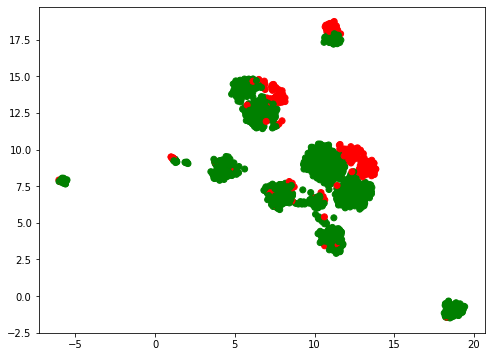

In [ ]:
color_labels = {'Yes':'red', 'No':'green'}

plt.figure(figsize=(8, 6))

# Scatter plot of the 2D embeddings as (x,y) values
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [color_labels[x] for x in data.Attrition]
    )

**Density-based spatial clustering of applications with noise (DBSCAN)**
Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

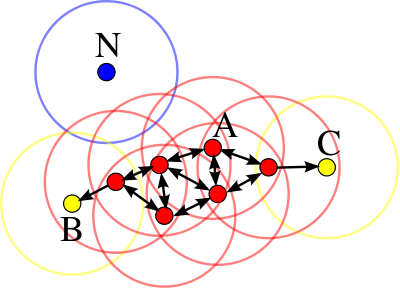

I chose DBSCAN as a clustering method, due to the table in the scikit-learn documentation. https://scikit-learn.org/stable/modules/clustering.html

In the table, there are various clustering methods, but the usecase fits the best for **DBSCAN** - the clusters have uneven sizes, there are not many clusters. Therefore I decided to use it.

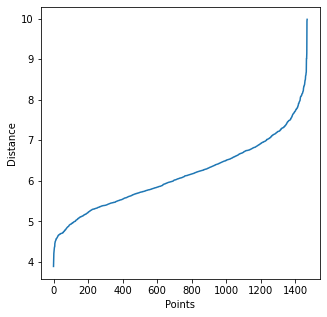

In [ ]:
# For estimatino of th epsilon in DBSCAN.
# The elbow points should be good epsilon values.
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(scaled_data)
distances, indices = neighbors.kneighbors(scaled_data)
distances = np.sort(distances[:,4], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Fit the data using DBSCAN
clustering = DBSCAN(eps=6.86, min_samples=80).fit(scaled_data)
print(np.unique(clustering.labels_))
print(data[clustering.labels_ == -1].groupby("Attrition")["Attrition"].count())
print(data[clustering.labels_ == 0].groupby("Attrition")["Attrition"].count())
print()
print(f"DBSCAN clustering error rate: {100*((466+62)/len(data)):.2f}%")

[-1  0]
Attrition
No     466
Yes    175
Name: Attrition, dtype: int64
Attrition
No     767
Yes     62
Name: Attrition, dtype: int64

DBSCAN clustering error rate: 35.92%


In [ ]:
print(f"clustering error rate: {100*((237)/1470):.2f}%")

clustering error rate: 16.12%


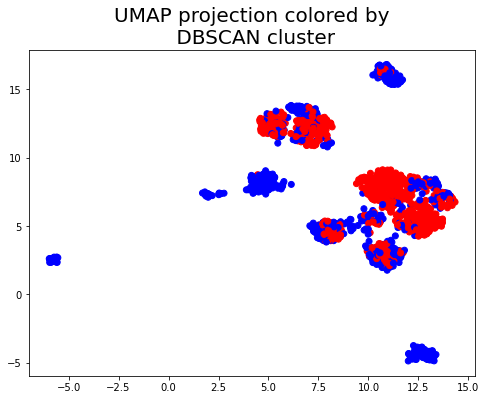

In [ ]:
# Assign a color to each DBSCAN cluster label
color_labels2 = {-1: 'blue', 0: 'red'}

# Create a figure
plt.figure(figsize=(8, 6))

# Scatter plot of the 2D embeddings as (x,y) values
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [color_labels2[x] for x in list(clustering.labels_)]
    )

# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection colored by\n DBSCAN cluster', fontsize=20);

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X)
print(data[kmeans.labels_ == 0].groupby("Attrition")["Attrition"].count())
print()
print(data[kmeans.labels_ == 1].groupby("Attrition")["Attrition"].count())

Attrition
No     605
Yes    119
Name: Attrition, dtype: int64

Attrition
No     628
Yes    118
Name: Attrition, dtype: int64


## Summary on clustering
I didn't manage to perform a clustering that would really fit the data properly. Probably it is because the data has been generated, and are not real. The closest I got was with the DBSCAN algorithm, but the error rate is still terrible.

# Hypotheses testing

### Hypothesis 1


I noticed, that it is very rare that the variables follow normal distribution. Let's see if there are some, which actually have the normal distribution.
I will check the distribution for continuos features. I would consider the following features continuous:
```
Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, MonthlyRate, PercentSalaryHike, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion and YearsWithCurrManager
```

H0: At least one variable has normal distribution.

H1: No variables has normal distribution.

α-level: 5%

I will use the Shapiro-Wilk tests. For this test, the null hypothesis is, that the data follow normal distribution. The test does not reject the null hypothesis, when the p-value is **higher** than the chosen alpha level.

In [ ]:
from scipy.stats import shapiro
alpha = 0.05
for col in ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','PercentSalaryHike', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']:
    result=shapiro(data[col])
    print('P-value for the ' + col + ' variable = ' + str(result[1]))
    if result[1] < alpha:
      print('Reject H0 for variable:', col)
    else:
      print('Cannot reject H0 for variable:', col)
    

P-value for the Age variable = 2.0348782405724304e-14
Reject H0 for variable: Age
P-value for the DailyRate variable = 5.33020646444966e-21
Reject H0 for variable: DailyRate
P-value for the DistanceFromHome variable = 4.085665715153025e-34
Reject H0 for variable: DistanceFromHome
P-value for the HourlyRate variable = 7.414142614934963e-21
Reject H0 for variable: HourlyRate
P-value for the MonthlyIncome variable = 4.403282003619775e-37
Reject H0 for variable: MonthlyIncome
P-value for the MonthlyRate variable = 5.515456551467108e-21
Reject H0 for variable: MonthlyRate
P-value for the PercentSalaryHike variable = 7.476110216992445e-30
Reject H0 for variable: PercentSalaryHike
P-value for the YearsAtCompany variable = 3.669912519577708e-36
Reject H0 for variable: YearsAtCompany
P-value for the YearsInCurrentRole variable = 2.140164071943242e-30
Reject H0 for variable: YearsInCurrentRole
P-value for the YearsSinceLastPromotion variable = 4.203895392974451e-45
Reject H0 for variable: YearsS

From the results of Shapiro tests, we can see, that none of the continuous variables do follow normal distribution.

 **Therefore we can reject the null hypothesis.**

 This can also be the

### Hypothesis 2

In the exploratory analysis of `DistanceFromHome` variable, I noticed that the distribution for `Attrition == Yes` and `Attrition == No` is not similar. The Kolmogrov-Smirnov test can be used to test wether the two distributions really are not similar. The KS test can only be used for continuous distribution. If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative. If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.

http://www.mit.edu/~6.s085/notes/lecture5.pdf

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp

H0: Distributions of DistanceFromHome are similar in the two attrition groups.

H1: Distributions of DistanceFromHome are **NOT** similar in the two attrition groups.

α-level: 5%

In [ ]:
from scipy import stats

data_no = data.DistanceFromHome[data.Attrition=='No']
data_yes = data.DistanceFromHome[data.Attrition=='Yes']

stats.ks_2samp(data_no, data_yes)

Ks_2sampResult(statistic=0.11493013849107353, pvalue=0.009527282524932623)

The p-value of the KS test is `0.009`, which is less than the alpha level. Therefore we can **reject the null hypothesis**, which confirms the results of the exploratory analysis.

### Hypothesis 3

The 3rd hypothesis will test, wether `Overtime` variable is significant variable for predicting Attrition. I will use the chi-square test of independence to check if these two variables are likely to be related. For the test we need two categorical variables. The null hypothesis for this test is that there is no relationship between the two variables.


H0: There is no relationship between `Overtime` and `Attrition` variables.

H1: There exists a relationship between `Overtime` and `Attrition` variables.

α-level: 5%


In [ ]:
# Frequency of Attrition
a_yes = data.Attrition[data.Attrition=='Yes'].count()
a_no = data.Attrition[data.Attrition=='No'].count()

# Frequency of Overtime
o_yes = data.OverTime[data.OverTime=='Yes'].count()
o_no = data.OverTime[data.OverTime=='No'].count()

print([a_yes, a_no], [o_yes, o_no])
print()

stats.chisquare([o_yes, o_no], f_exp=[a_yes, a_no])


[237, 1233] [416, 1054]



Power_divergenceResult(statistic=161.18030531686634, pvalue=6.248439694790742e-37)

As we can see, the resulting p-value is `6.248e-37`, which is less then the selected alpha level. Therefor we accept H1 - there is a significant relationship between `Overtime` and `Attrition`.

#Attrition predictive model

In [ ]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df


dummies = df_column_switch(dummies, "Age", "Attrition_No")
dummies = df_column_switch(dummies, "DailyRate", "Attrition_Yes")
dummies


,Attrition_No,Attrition_Yes,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Age,DailyRate,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,1,1,2,1,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,41,1102,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,1,0,8,1,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,49,279,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
2,0,1,2,2,1,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,37,1373,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,1,0,3,4,1,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,33,1392,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,1,0,2,1,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,27,591,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,0,23,2,1,3,41,4,2,4,2571,12290,4,17,3,3,1,17,3,3,5,2,0,3,36,884,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1466,1,0,6,1,1,4,42,2,3,1,9991,21457,4,15,3,1,1,9,5,3,7,7,1,7,39,613,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1467,1,0,4,3,1,2,87,4,2,2,6142,5174,1,20,4,2,1,6,0,3,6,2,0,3,27,155,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1468,1,0,2,3,1,4,63,2,2,2,5390,13243,2,14,3,4,0,17,3,2,9,6,0,8,49,1023,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# define dataset
X = dummies.iloc[:, 2:].values
y = dummies.iloc[:, 1:2].values
# define model
model = LinearDiscriminantAnalysis()
model.fit(X,y)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Accuracy: 0.878 (0.021)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


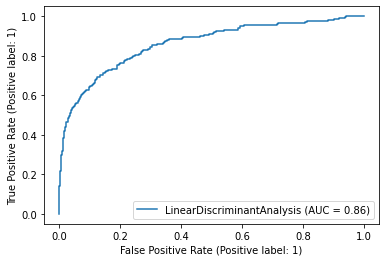

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X, y)

In [ ]:

df_importance = pd.DataFrame(np.array(model.coef_[0]), index = dummies.columns[2:], columns=["Importance"])

df_importance.apply(np.abs).sort_values(ascending=False, by='Importance').head(20)


,Importance
JobRole_Sales Representative,1.731836
JobRole_Human Resources,1.335007
EducationField_Human Resources,1.078293
Department_Human Resources,1.075877
OverTime_Yes,1.047895
OverTime_No,1.047895
JobRole_Research Director,0.829825
BusinessTravel_Non-Travel,0.813844
JobRole_Healthcare Representative,0.808589
EducationField_Technical Degree,0.808048


#Discussion of the results

In the exploratory analysis part, I tried to do dimensionality reduction and clustering. I think it was not very successful, as the error rate was high. I noticed some patterns in the data by visualising it and I tried to briefly summarize the observations. I plotted a correlation heatmap, which in my opinion displays all the relationships between variables. When I think about the correlation carefully, all the correlations make sense. Also I deleted some predictors, which looked useless.

Then I took three of those observations and tested them formally with hypotheses. It was a bit tricky, as most of the methods taught in SAN required normal distribution. And none of the variables follow normal distribution, as I found out in the first hypothesis testing.

For prediction model I chose LDA over logistic regression, as I already had some experience with LDA (from HW). I had to convert the data to numeric values, in order to run LDA properly. I trained the model and I ran a 10-fold cross validation with 3 repetitions. The model had 87.8% classification accuraccy, which I consider a success. When I tried logistic regression, the accuracy was a tiny bit lower, but maybe that was due to the parameters. The ROC curve looks good as well. 

From the LDA model, I was also able to determine the most important features, which indicates employee attrition. The most important variables are visible in the last table. The most surprising fact for me is that martial status is an important attribute in attrition prediction. I would not expect that one. 



